In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython import display
import pylab as pl
from scipy.io import wavfile


from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 
from bss_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Sound Separation'

In [2]:
sound_paths = '../../data/Sounds'
sounds = []

rate, a = wavfile.read(os.path.join(sound_paths, 'music.wav'))
rate, b = wavfile.read(os.path.join(sound_paths, 'synth3.wav'))
rate, c = wavfile.read(os.path.join(sound_paths, 'bass1.wav'))
rate, d = wavfile.read(os.path.join(sound_paths, 'bassg1.wav'))
rate, e = wavfile.read(os.path.join(sound_paths, 'bluesg1.wav'))

a = a.astype('float64')
b = b.astype('float64')
c = c.astype('float64')
d = d.astype('float64')
e = e.astype('float64')

a_max = np.max(a)
b_max = np.max(b)
c_max = np.max(c)
d_max = np.max(d)
e_max = np.max(e)

a /= a_max
b /= b_max
c /= c_max
d /= d_max
e /= e_max

shortest = min(len(a), len(b), len(c), len(d), len(e))
a = a[:shortest][:,0]
b = b[:shortest][:,0]
c = c[:shortest][:,0]
d = d[:shortest][:,0]
e = e[:shortest][:,0]

S = np.stack((a, b, c, d, e))[[3,4]]

print(S.shape)
display_matrix(np.corrcoef(S))

(2, 396288)


<IPython.core.display.Math object>

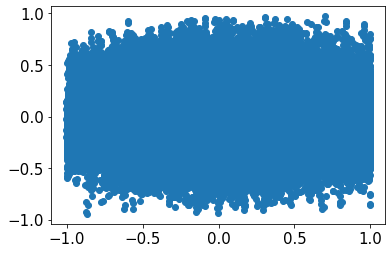

In [3]:
plt.figure()
plt.scatter(S[0,:], S[1,:])

In [4]:
np.random.seed(250)
NumberofMixtures = 2
NumberofSources = 2

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 40.003461349807566
Row standard deviation of mixtures : [0.30922397 0.57413854]


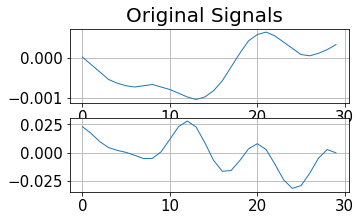

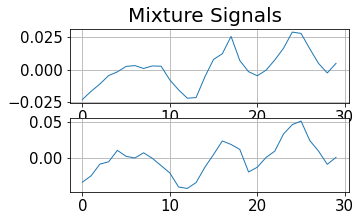

In [5]:
subplot_1D_signals(
    S[:, 1000:1030], title="Original Signals", figsize=(5, 3), colorcode=None
)
subplot_1D_signals(
    X[:, 1000:1030], title="Mixture Signals", figsize=(5, 3), colorcode=None
)

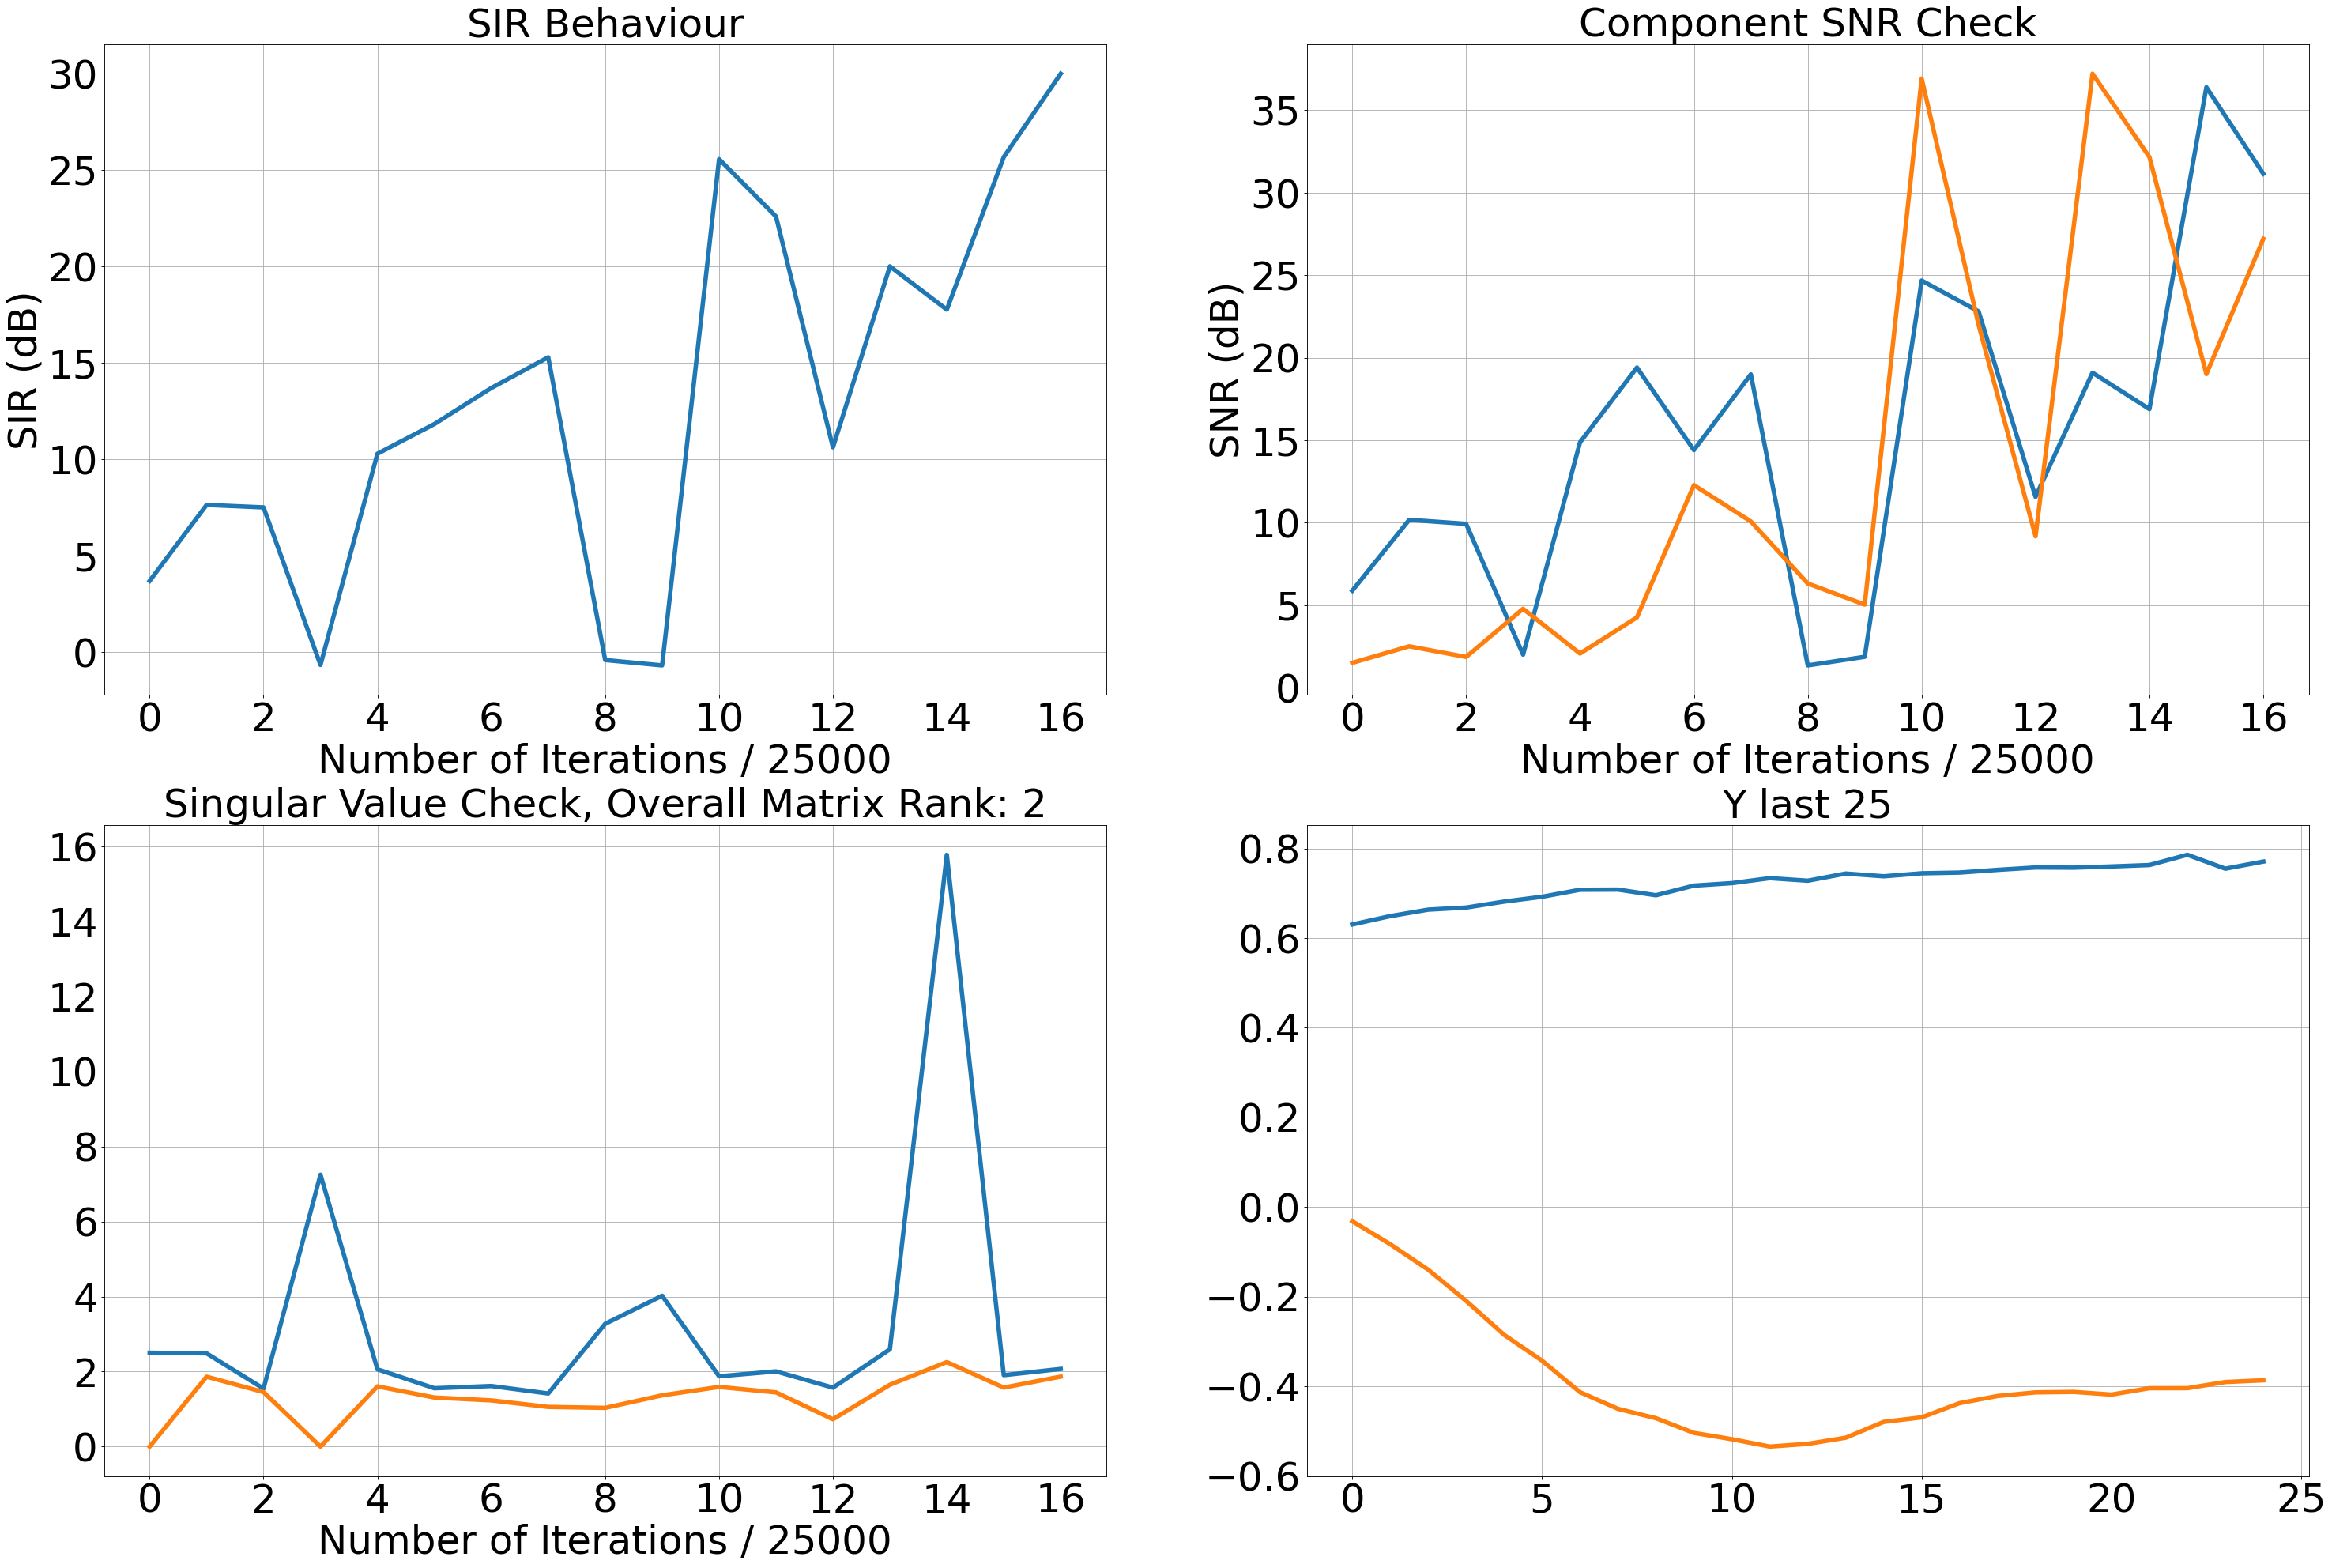

100%|██████████| 396288/396288 [03:41<00:00, 1791.19it/s]


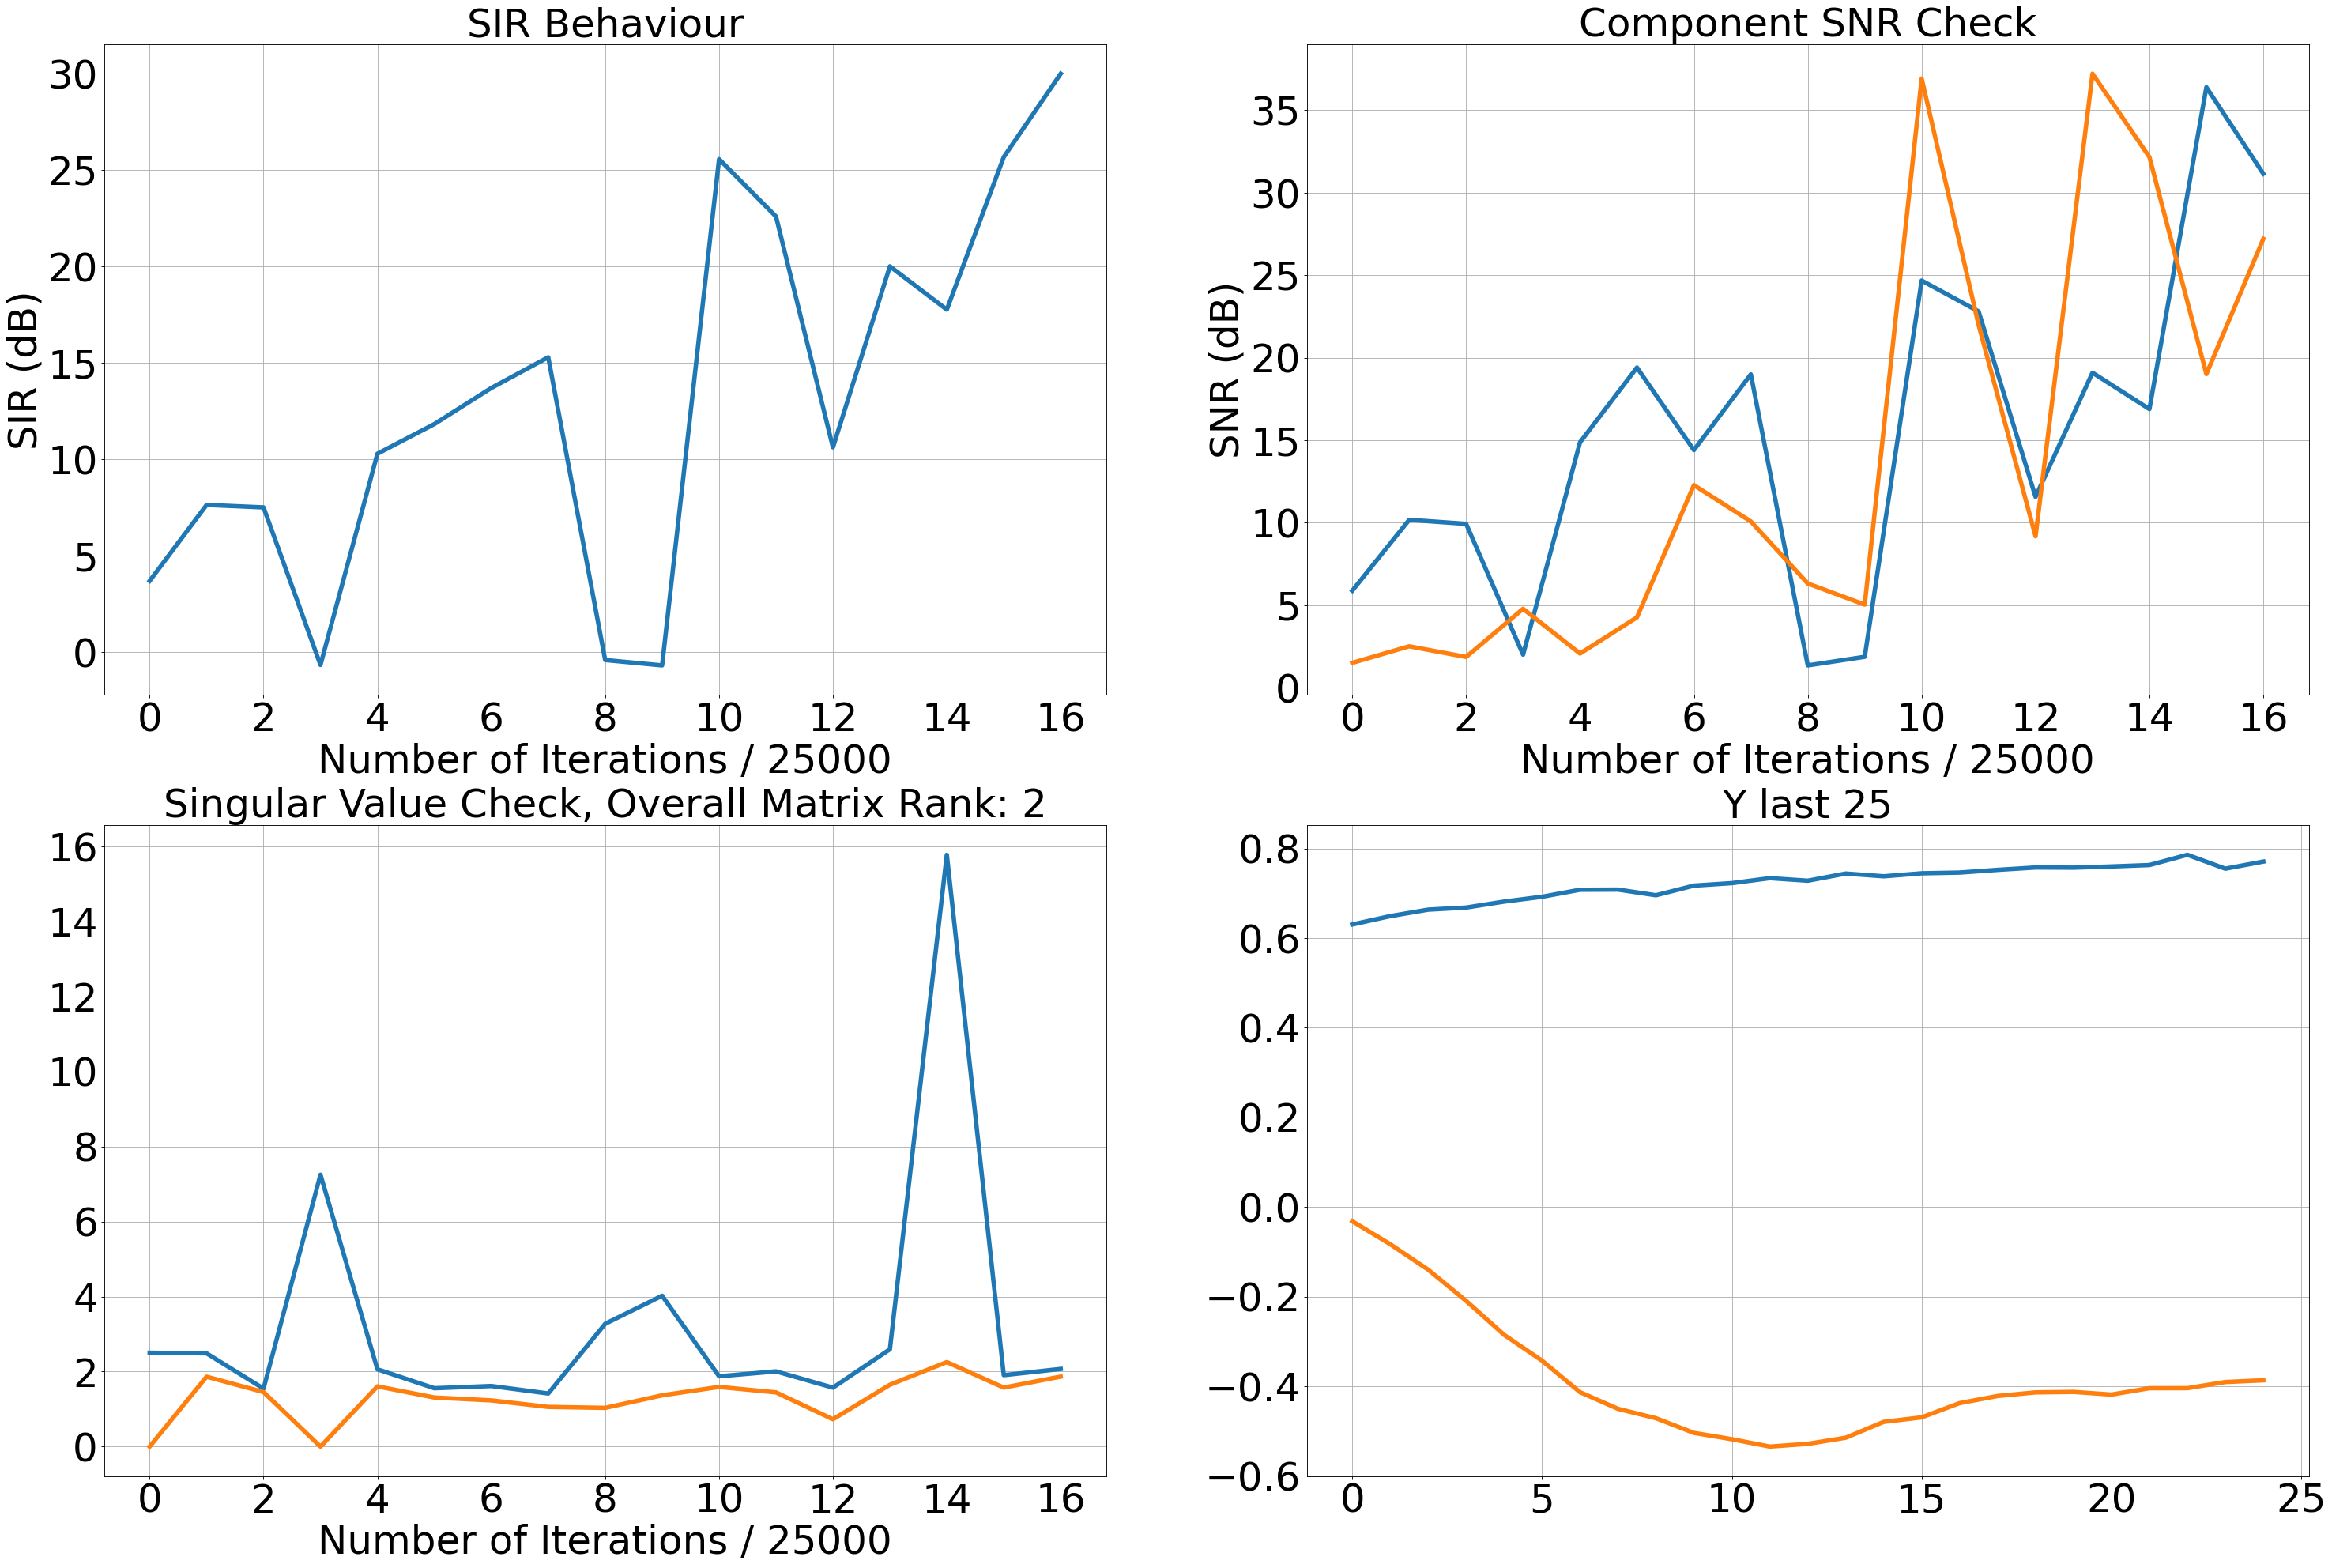

In [6]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 25000

lambday = 1 - 1e-1/10
lambdae = 0.5
lambdae = 1 - 1e-1/10
# Inverse output covariance
By = 10 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

modelCorInfoMax = OnlineCorInfoMax( s_dim = s_dim, x_dim = x_dim, muW = 50*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = S, A = A)
with Timer() as t:
    modelCorInfoMax.fit_batch_antisparse(   X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                                            plot_in_jupyter = True,
                                            neural_lr_start = 0.1,
                                            neural_lr_stop = 0.0001, 
                                            debug_iteration_point = debug_iteration_point, 
                                            shuffle = False)

In [7]:
WfCorInfoMax = modelCorInfoMax.compute_overall_mapping(return_mapping = True)
YCorInfoMax = WfCorInfoMax @ X
SINRCorInfoMax, SNRCorInfoMax, _, _, _ = evaluate_bss(WfCorInfoMax, YCorInfoMax, A, S, mean_normalize_estimations = False)
SINRCorInfoMax, SNRCorInfoMax

(30.010424932607588, array([31.14890211, 27.20043756]))